In [1]:
%reload_ext tensorboard
%reload_ext autoreload

# Energy Based Model

In [2]:
import os
import time
import math
import torch
import numpy as np
import torch.nn as nn
import pytorch_lightning as pl
import torch.nn.functional as F
import torch.distributions as tdist

from joblib import dump, load
from sklearn.decomposition import PCA
from pdmtut.core import GenerativeModel
from pytorch_lightning import loggers as pl_loggers

In [3]:
store_results = True
load_models = True

## Introduction

## Implementation

In [4]:
class EnergyBasedModel(pl.LightningModule, GenerativeModel):
    class Decoder(nn.Module):
        def __init__(self):
            super().__init__()
            self.dec1 = nn.Linear(2, 64)
            self.decbn1 = nn.BatchNorm1d(num_features=64)
            self.dec2 = nn.Linear(64, 128)
            self.decbn2 = nn.BatchNorm1d(num_features=128)
            self.dec3 = nn.Linear(128, 128)
            self.decbn3 = nn.BatchNorm1d(num_features=128)
            self.dec4 = nn.Linear(128, 64)
            self.dec5 = nn.Linear(64, 3)

        def forward(self, z):
            x = F.elu(self.decbn1(self.dec1(z)))
            x = F.elu(self.decbn2(self.dec2(x)))
            x = F.elu(self.decbn3(self.dec3(x)))
            x = F.elu(self.dec4(x))
            x = self.dec5(x)
            return x
           
    def __init__(self):
        super().__init__()
        self.decoder = EnergyBasedModel.Decoder()

    def sample_z(self, n_samples, n_zs):
        # z ∈ [-1, 1]
        return (torch.rand(n_samples, n_zs, 2)*2 -1).to(self.device)

    def encode(self, X, n_steps=1000):
        zs = self.sample_z(X.shape[0], 1).squeeze(1).requires_grad_(True)
        _optimiser = torch.optim.SGD([zs], lr=0.1)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(_optimiser, 'min')

        for _ in range(n_steps):
            _optimiser.zero_grad()
            
            # mse reconstruction error 
            y_star = self.decoder(zs) # B*S
            mse = ((X - y_star)**2).sum(-1)
            
            # loss
            loss = mse.mean() 
            
            scheduler.step(loss)
            loss.backward()
            _optimiser.step()

        return zs.detach().cpu()


    def decode(self, X):
        return self.decoder(X).detach().cpu()
    
    def save(self, path):
        torch.save(self, os.path.join(path, 'model.pt'))
    
    def load(path):
        return torch.load(os.path.join(path, 'model.pt'))
            
    def save_exists(path):
        return (
            os.path.isfile(os.path.join(path, 'model.pt')))

    def log_likelihood(self, X):
        return -self.beta_free_energy(X).detach().cpu()

    def sample_posterior(self, n_samples):
        zs = self.sample_z(n_samples, 1).squeeze(1)
        return self.decoder(zs).detach().cpu()

    def energy(self, y, z):
        # Expected format BxS where S is the amount of samples

        y_star = self.decoder(z.view(-1, z.shape[-1])) # B*S
        y_star = y_star.view(y.shape[0], -1, 3) # BxSx2

        return ((y[:,None] - y_star)**2).sum(-1)

    def beta_free_energy(self, y, zs=None, n_zs=100, beta=80):
        if zs is None:
            zs = self.sample_z(y.shape[0], n_zs)

        E = self.energy(y, zs).view(-1, n_zs)

        loss = -(1/beta) * torch.logsumexp(-beta*E, -1)
        return loss
    
    def fit_model(self, X, X_val=None, path=None):
        start_time = time.time()
        
        if path is None:
            tb_logger = False
            checkpoint_callback=False
        else:
            tb_logger = pl_loggers.TensorBoardLogger(path, version=1)
            checkpoint_callback=True
        
        trainer = pl.Trainer(
            max_epochs=2000, gpus=1, logger=tb_logger,
            checkpoint_callback=checkpoint_callback
        )
        trainer.fit(
            self, train_dataloaders=X, val_dataloaders=X_val)
        elapsed_time = time.time() - start_time
        
        if path is not None: 
            with open(os.path.join(path, 'training_time.txt'), 'w') as f:
                f.write(str(elapsed_time))

    def training_step(self, batch, batch_idx):
        batch = batch[0]

        loss = self.beta_free_energy(batch).mean()

        self.log('train_loss', loss)
        return {'loss': loss}
    
    def validation_step(self, batch, batch_idx):
        batch = batch[0]

        loss = self.beta_free_energy(batch).mean()

        self.log('validation_loss', loss)
        return {'val_loss': loss}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-2)
        return {
            'optimizer': optimizer,
            'lr_scheduler':
            torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, min_lr=1e-8, factor=0.5, verbose=True,
                # todo: change back to 100
                patience=300
            ), 'monitor': 'train_loss'
        }

    def __str__(self):
        return 'ebm'


## Experiment 1: swiss roll

In [5]:
import pyvista as pv
from pdmtut.datasets import SwissRoll

In [6]:
pv.set_plot_theme("document")

model_save_path = '../results/swiss_roll/ebm'

if store_results:
    result_save_path = '../results/swiss_roll/ebm'
    pv.set_jupyter_backend('None')
else:
    pv.set_jupyter_backend('ipygany')
    result_save_path = None

In [7]:
dataset = SwissRoll(n_samples=100**2, seed=11)

if load_models and EnergyBasedModel.save_exists(model_save_path):
    model = EnergyBasedModel.load(model_save_path)
else:
    model = EnergyBasedModel()
    model.fit_model(
        X=dataset.train_loader(batch_size=512),
        X_val=dataset.validation_loader(batch_size=512),
        path=result_save_path)
    
    if store_results:
        model.save(model_save_path)
        
model = model.eval()

In [8]:
%tensorboard --logdir ../results/swiss_roll/ebm

### Input Representation

In [9]:
from pdmtut.vis import plot_representation

In [10]:
z = model.encode(dataset.X)
z_extremes = model.encode(dataset.y_extremes)
z_extremes = torch.cat([z_extremes, z_extremes[[1,2]]])

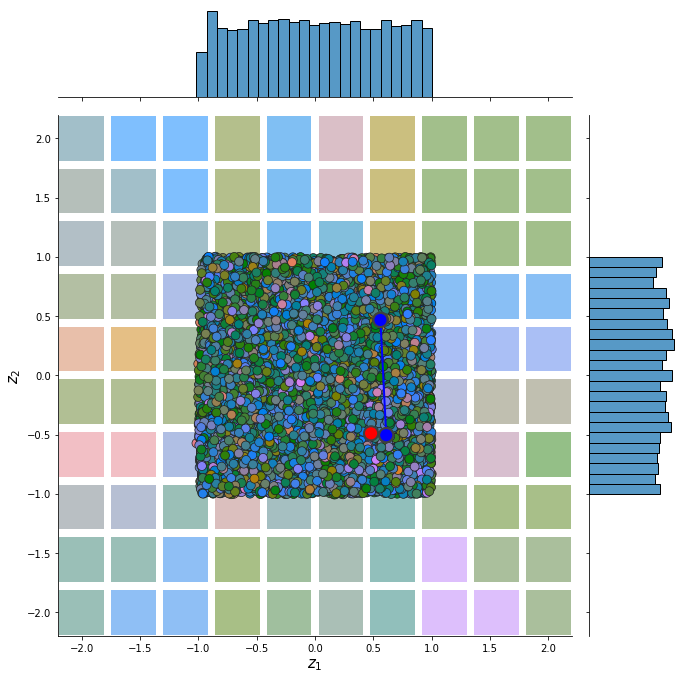

In [11]:
plot_representation(z.numpy(), index_colors=dataset.index_colors, z_extremes=z_extremes, interpolate_background=True, root=result_save_path)

### Input Reconstruction

In [12]:
from pdmtut.vis import plot_reconstruction

In [13]:
z = model.encode(dataset.X)
x = model.decode(z)

In [14]:
mse = (dataset.unnormalise_scale(dataset.X) - dataset.unnormalise_scale(x)).pow(2).sum(-1).mean()

if result_save_path is not None: 
    with open(os.path.join(result_save_path, 'reconstruction.txt'), 'w') as f:
        f.write(str(mse.item()))
        
mse

tensor(135.4865)

In [15]:
plot_reconstruction(dataset.unnormalise_scale(x).numpy(), dataset.index_colors, root=result_save_path)

Scene(background_color='#ffffff', camera={'position': [-32.5, 0.0, 32.5], 'target': (0.0, 0.0, 0.0), 'up': (0.…

### Density Estimation

In [16]:
from pdmtut.vis import plot_density

In [17]:
log_likelihood = model.log_likelihood(dataset.X)

In [18]:
data_log_likelihood = log_likelihood.mean()

if result_save_path is not None: 
    with open(os.path.join(result_save_path, 'density.txt'), 'w') as f:
        f.write(str(data_log_likelihood.item()))
        
data_log_likelihood

tensor(-0.0095)

In [19]:
plot_density(dataset.unnormalise_scale(dataset.X).numpy(), log_likelihood.numpy(), root=result_save_path)

AppLayout(children=(VBox(children=(HTML(value='<h3>Log probability</h3>'), Dropdown(description='Colormap:', o…

### Generate Samples

In [20]:
from pdmtut.vis import plot_generated_samples

In [21]:
generated_samples = model.sample_posterior(100**2)
generated_samples_log_likelihood = model.log_likelihood(generated_samples)

In [22]:
plot_generated_samples(dataset.unnormalise_scale(generated_samples).numpy(), generated_samples_log_likelihood.numpy(), root=result_save_path)

AppLayout(children=(VBox(children=(HTML(value='<h3>Log probability</h3>'), Dropdown(description='Colormap:', o…

### Interpolation

In [23]:
from pdmtut.vis import plot_interpolation
from scipy.interpolate import interp1d

In [24]:
z_extremes = model.encode(dataset.y_extremes)
uniform_state, uniform_log_prob, _ = dataset.sample_points_uniformly(n_samples=100**2, seed=11)

linfit1 = interp1d([1,20], z_extremes[:2].numpy(), axis=0)
linfit2 = interp1d([1,20], z_extremes[2:].numpy(), axis=0)
linfit3 = interp1d([1,20], z_extremes[[1,2]].numpy(), axis=0)

interpolated_points_1 = model.decode(torch.Tensor(linfit1(np.arange(1,21))))
interpolated_points_2 = model.decode(torch.Tensor(linfit2(np.arange(1,21))))
interpolated_points_3 = model.decode(torch.Tensor(linfit3(np.arange(1,21))))

/home/bawaw/.conda/envs/pdm_tutorial/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180588308/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [25]:
plot_interpolation(
    dataset.unnormalise_scale(interpolated_points_1).numpy(), 
    dataset.unnormalise_scale(interpolated_points_2).numpy(), 
    dataset.unnormalise_scale(interpolated_points_3).numpy(), 
    uniform_state.detach().view(100, 100, 3).permute(2, 0, 1).numpy(),
    uniform_log_prob.numpy(), root=result_save_path
)

AppLayout(children=(VBox(children=(HTML(value='<h3>Log probability</h3>'), Dropdown(description='Colormap:', o…

## Extra
### Sample generation with embedding colors

In [26]:
import pickle
import pyvista as pv

In [27]:
z = model.encode(dataset.X)
generative_samples = model.decode(z)
index_colors = dataset.color_map(z)

In [ ]:
plotter = pv.Plotter() 

plotter.add_mesh(
    pv.PolyData(dataset.unnormalise_scale(generative_samples).detach().numpy()),
    render_points_as_spheres=True, point_size=10,
    diffuse=0.99, specular=0.8, ambient=0.3, smooth_shading=True,
    scalars=index_colors,
    style='points', rgb=True
)

plotter.camera_position = [(-65, 0, 65), (0, 0, 0), (0, 1, 0)]

_ = plotter.show(window_size=[800, 800])

if result_save_path is not None:
    plotter.screenshot(os.path.join(result_save_path, 'z_colored_sample_reconstruction.png'))
    pickle.dump({
        'reconstructed_state': z,
        'index_colors': dataset.index_colors
    }, open(os.path.join(result_save_path, 'z_colored_sample_reconstruction.obj'), 'wb'))

Scene(background_color='#ffffff', camera={'position': [-32.5, 0.0, 32.5], 'target': (0.0, 0.0, 0.0), 'up': (0.…

### Energy space

In [29]:
uniform_state, uniform_log_prob, _ = dataset.sample_points_uniformly(n_samples=100**2, seed=11)

In [30]:
point_grid = torch.stack(torch.meshgrid(torch.linspace(-20,20,200), torch.linspace(-20,20,200)),-1).view(-1,2)

# X-Y plane
x_y_point_grid = torch.stack([point_grid[:, 0], point_grid[:, 1], torch.zeros_like(point_grid[:, 0])], -1)
x_y_energy = model.beta_free_energy(
    dataset.normalise_scale(x_y_point_grid)).detach()

plotter = pv.Plotter()
plotter.add_mesh(pv.PolyData(x_y_point_grid.detach().numpy()), render_points_as_spheres=False,
                    point_size=5, scalars=x_y_energy , clim=[x_y_energy.min(), x_y_energy.max()])

plotter.add_mesh(pv.StructuredGrid(*uniform_state.detach().view(100, 100, 3).permute(2, 0, 1).numpy()), opacity=0.5, color='grey')

plotter.camera_position = [(0,0,80), (0,0,0), (0,1,0)]
_ = plotter.show(window_size=[800, 800])


if result_save_path is not None:
    plotter.screenshot(os.path.join(result_save_path, 'energy_ambient_XY.png'))

AppLayout(children=(VBox(children=(HTML(value='<h3></h3>'), Dropdown(description='Colormap:', options={'BrBG':…

In [31]:
point_grid = torch.stack(torch.meshgrid(torch.linspace(-20,20,200), torch.linspace(-20,20,200)),-1).view(-1,2)

# X-Z plane
x_y_point_grid = torch.stack([point_grid[:, 0], torch.zeros_like(point_grid[:, 0]), point_grid[:, 1]], -1)
x_y_energy = model.beta_free_energy(
    dataset.normalise_scale(x_y_point_grid)).detach()

plotter = pv.Plotter()
plotter.add_mesh(pv.PolyData(x_y_point_grid.detach().numpy()), render_points_as_spheres=False,
                    point_size=5, scalars=x_y_energy , clim=[x_y_energy.min(), x_y_energy.max()])

plotter.add_mesh(pv.StructuredGrid(*uniform_state.detach().view(100, 100, 3).permute(2, 0, 1).numpy()), opacity=0.5, color='grey')

plotter.camera_position = [(0,80,0), (0,0,0), (1,0,0)]
_ = plotter.show(window_size=[800, 800])

if result_save_path is not None:
    plotter.screenshot(os.path.join(result_save_path, 'energy_ambient_XZ.png'))

AppLayout(children=(VBox(children=(HTML(value='<h3></h3>'), Dropdown(description='Colormap:', options={'BrBG':…

In [32]:
point_grid = torch.stack(torch.meshgrid(torch.linspace(-20,20,200), torch.linspace(-20,20,200)),-1).view(-1,2)

# Y-Z plane
x_y_point_grid = torch.stack([torch.zeros_like(point_grid[:, 0]), point_grid[:, 0], point_grid[:, 1]], -1)
x_y_energy = model.beta_free_energy(
    dataset.normalise_scale(x_y_point_grid)).detach()

plotter = pv.Plotter()
plotter.add_mesh(pv.PolyData(x_y_point_grid.detach().numpy()), render_points_as_spheres=False,
                    point_size=5, scalars=x_y_energy , clim=[x_y_energy.min(), x_y_energy.max()])

plotter.add_mesh(pv.StructuredGrid(*uniform_state.detach().view(100, 100, 3).permute(2, 0, 1).numpy()), opacity=0.5, color='grey')

plotter.camera_position = [(80,0,0), (0,0,0), (0,1,0)]
_ = plotter.show(window_size=[800, 800])

if result_save_path is not None:
    plotter.screenshot(os.path.join(result_save_path, 'energy_ambient_YZ.png'))

AppLayout(children=(VBox(children=(HTML(value='<h3></h3>'), Dropdown(description='Colormap:', options={'BrBG':…